# Тестовое задание Data Science №2:

- Задача: создать прогностическую модель рисков беременных.
- Срок: до 1 недели
- Метрика: accuracy
- Как сдавать: ссылку на google colab с выводами.Обязательно вывести матрицу ошибок на тесте.
- Особенности: В последних ячейках необходимо
вывести метрики и матрицу ошибок на трейне и тесте.
---
Описание:
- Age: Age количество лет на момент беременности
- SystolicBP: Систолическое артериальное давление (верхнее значение артериального давления) в миллиметрах ртутного столба (мм рт. ст.) является значимым атрибутом во время беременности.
- DiastolicBP: Диастолическое артериальное давление (нижнее значение артериального давления) в миллиметрах ртутного столба (мм рт. ст.) также является значимым атрибутом во время беременности.
- BS: Уровень глюкозы в крови измеряется в молярной концентрации и выражается в миллимолях на литр (ммоль/л).
- BodyTemp: Температура тела по фаренгейту.
- HeartRate: Нормальный уровень покоя частоты сердечных сокращений измеряется в ударах в минуту.
- Risk Level: Прогнозируемый Уровень интенсивности риска во время беременности с учетом предыдущего признака.

In [ ]:
#pip install xgboost

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from google.colab import files
uploaded = files.upload()

Saving Maternal Health Risk Data Set.csv to Maternal Health Risk Data Set (8).csv


In [ ]:
maternal_health_risk = pd.read_csv('Maternal Health Risk Data Set.csv')

In [ ]:
maternal_health_risk.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [ ]:
maternal_health_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


видим,что тип данных верный

In [ ]:
maternal_health_risk.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


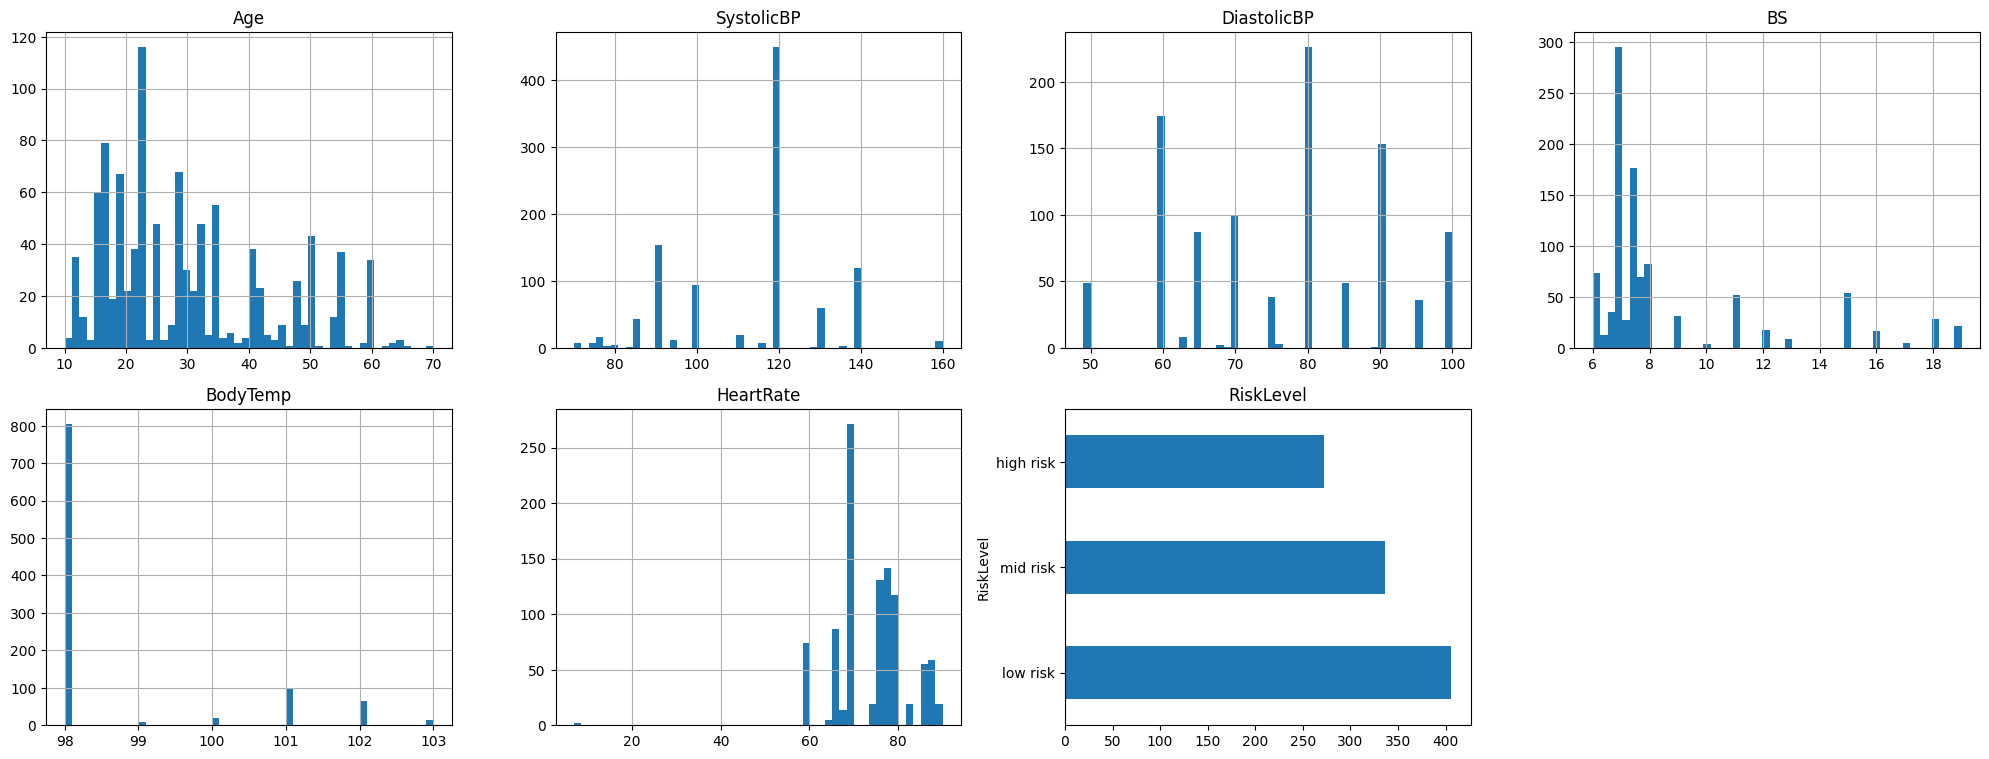

In [ ]:
fig = plt.figure(figsize=(20, 15))
for i, column in enumerate(maternal_health_risk.columns):
    fig.add_subplot(4, 4, i + 1)
    if maternal_health_risk[column].dtype == 'object':
        maternal_health_risk[column].value_counts().plot(kind='barh')
        plt.title(column)
    else:
        maternal_health_risk[column].hist(bins = 50)
        plt.title(column)
plt.tight_layout()
plt.show()

*Вывод:*
- Тип данных во всех столбцах- верный
- Видим аномальные значение в HeartRate

# Предобработка данных
## Приведем к змеиному регистру

In [ ]:
maternal_health_risk.columns = maternal_health_risk.columns.str.lower()
maternal_health_risk.head()

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Посмотрим пропуски

In [ ]:
maternal_health_risk.isna().sum()

,0
age,0
systolicbp,0
diastolicbp,0
bs,0
bodytemp,0
heartrate,0
risklevel,0


Пропусков нет

## Неявные дубликаты

In [ ]:
maternal_health_risk['risklevel'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

Неявных дубликатов - нет

**Вывод:**
- привели к змеиному регистру заголовки
- пропусков нет
- неявных дубликатов - нет

# Исследовательский анализ данных

## Анализ рисков

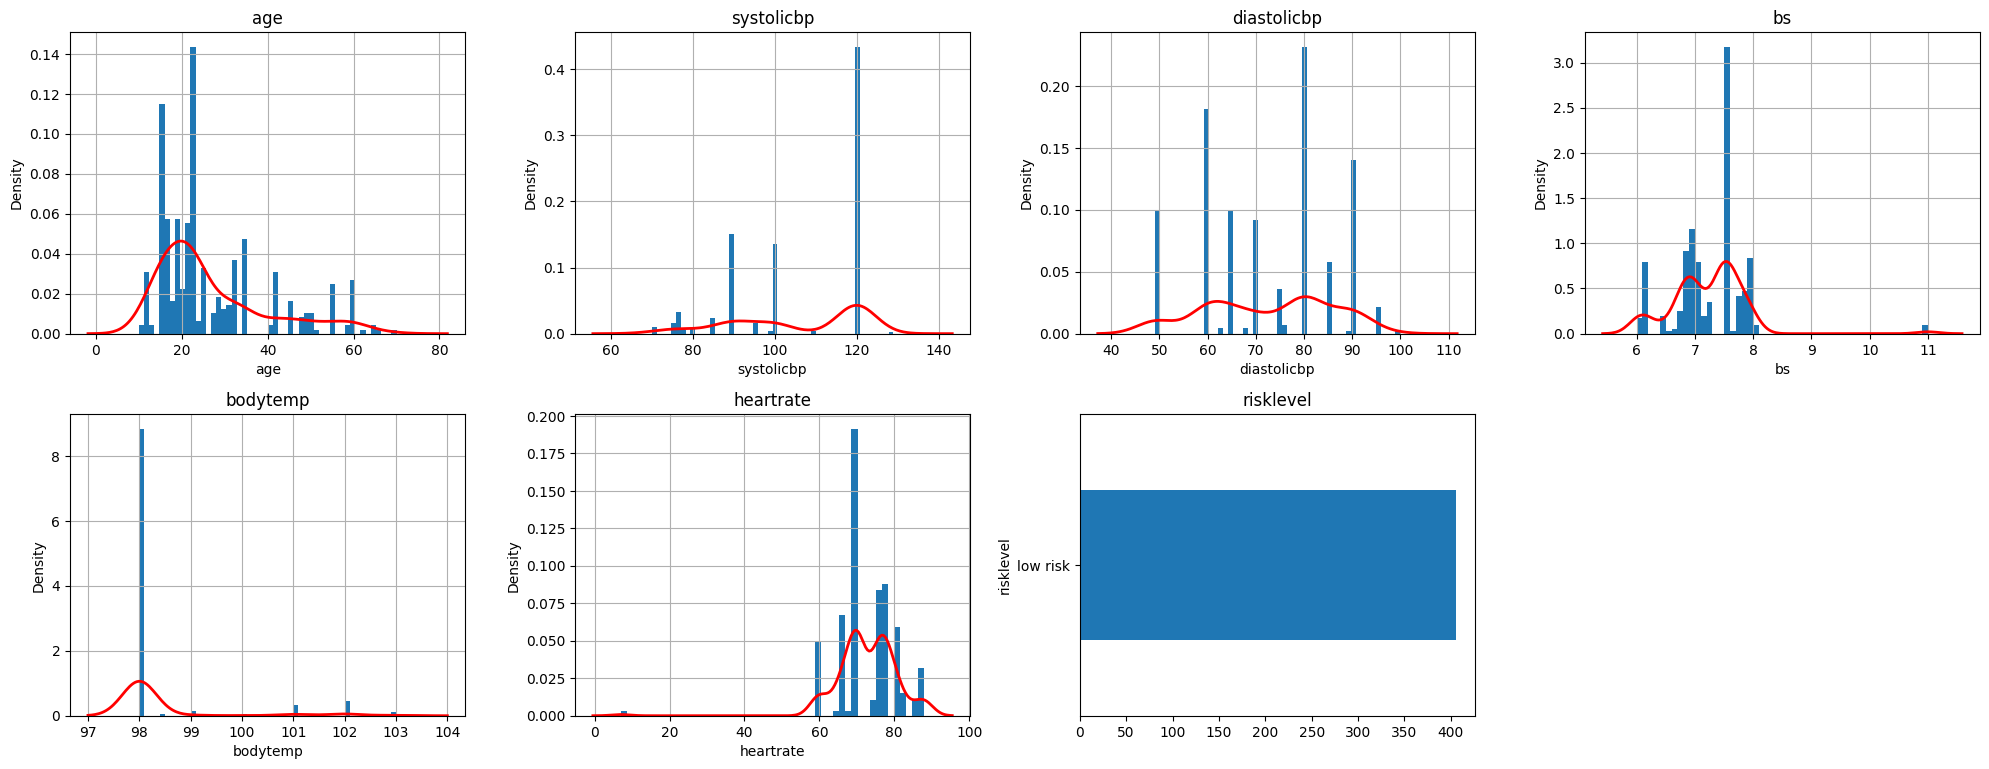

In [ ]:
low_risk_data = maternal_health_risk.query('risklevel == "low risk"')
fig = plt.figure(figsize=(20, 15))
for i, column in enumerate(low_risk_data.columns):
    ax = fig.add_subplot(4, 4, i + 1)
    if low_risk_data[column].dtype == 'object':
        low_risk_data[column].value_counts().plot(kind='barh', ax=ax)
        plt.title(column)
    else:
        low_risk_data[column].hist(bins=50, density=True)
        sns.kdeplot(low_risk_data[column], color='red', linewidth=2)
        plt.title(column)
plt.tight_layout()

Низкий риск характеризуется чаще всего:
- Возраст: 16;20 лет
- Систолическое давление: 120
- Диастолическое давление: 60,80
- Уровень глюкозы в крови: 7,5
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70

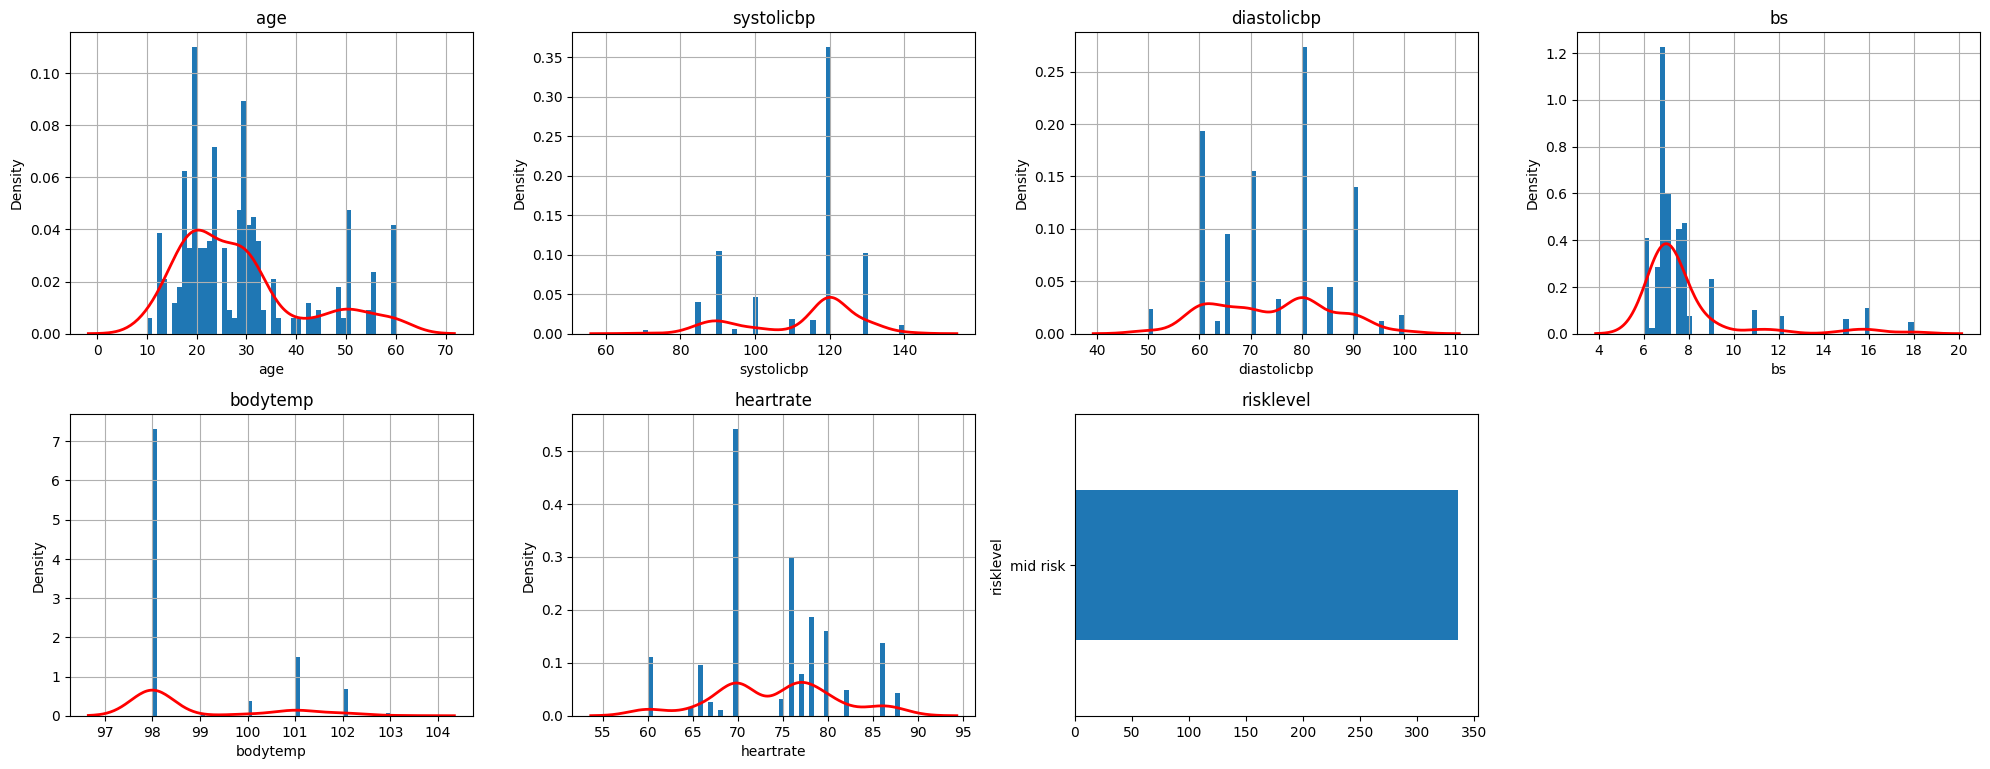

In [ ]:
medium_risk_data = maternal_health_risk.query('risklevel == "mid risk"')
fig = plt.figure(figsize=(20, 15))
for i, column in enumerate(medium_risk_data.columns):
    fig.add_subplot(4, 4, i + 1)
    if medium_risk_data[column].dtype == 'object':
        medium_risk_data[column].value_counts().plot(kind='barh')
        plt.title(column)
    else:
        medium_risk_data[column].hist(bins = 50, density=True)
        sns.kdeplot(medium_risk_data[column], color='red', linewidth=2)
        plt.title(column)
plt.tight_layout()
plt.show()

Средний риск характеризуется чаще всего:
- Возраст: 20;30 лет
- Систолическое давление: 120
- Диастолическое давление: 80
- Уровень глюкозы в крови: 6-8
- Температура тела в фаренгейтах: 98 (повышается количество людей с 101, относительно высокого риска)
- Частота сердечных сокращений: 70

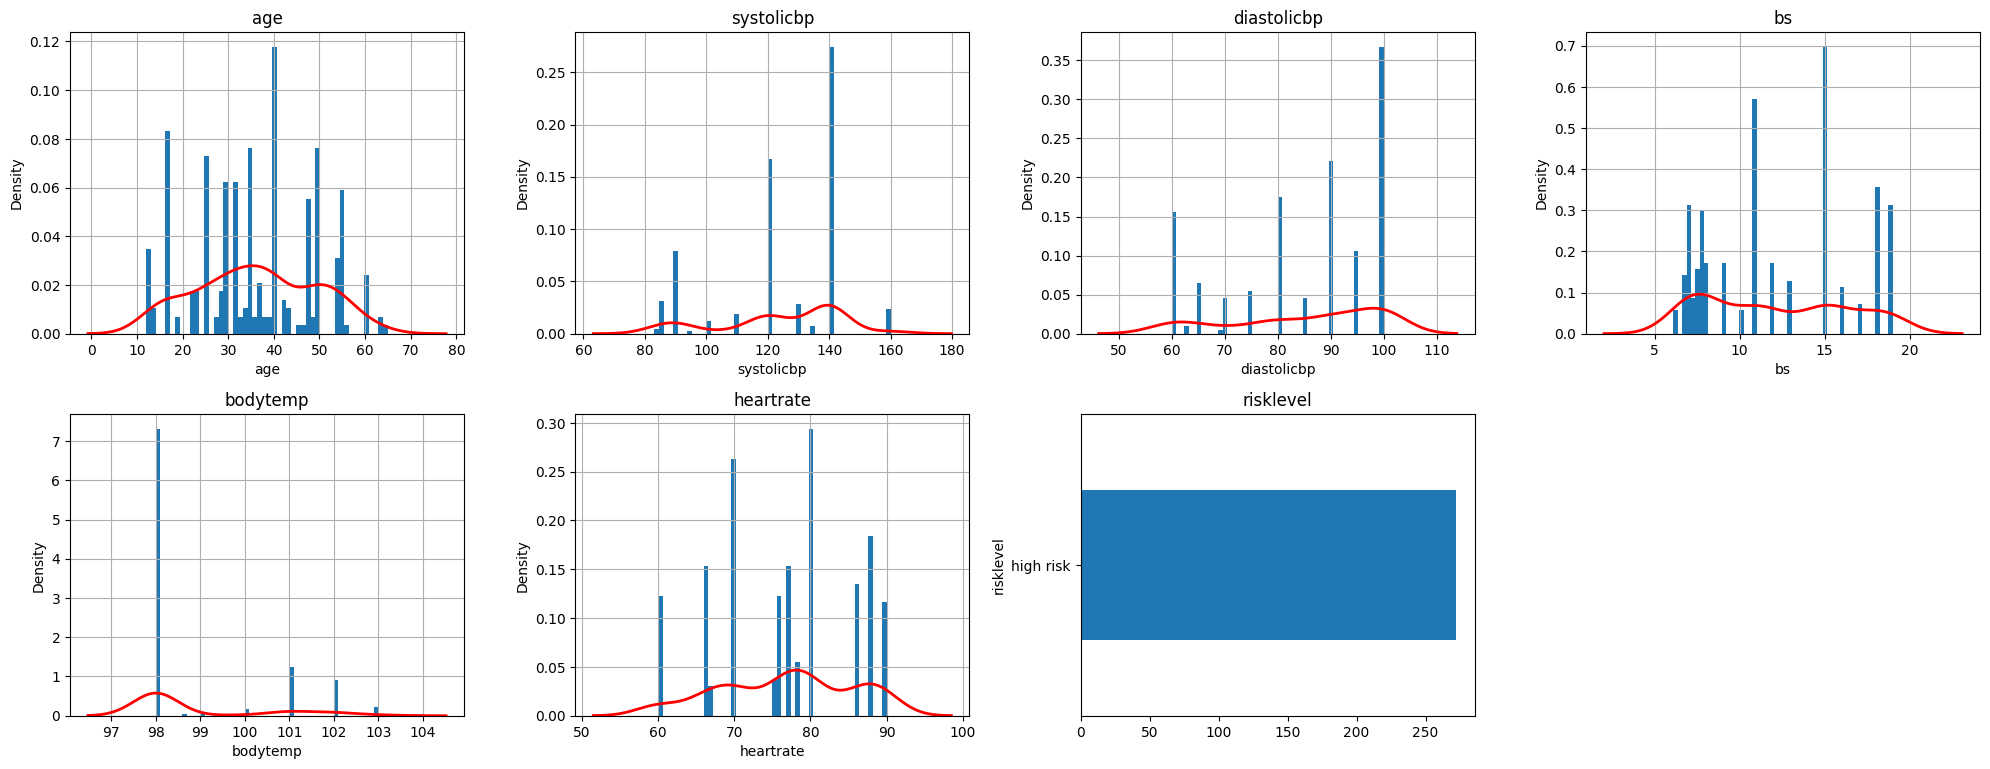

In [ ]:
high_risk_data = maternal_health_risk.query('risklevel == "high risk"')
fig = plt.figure(figsize=(20, 15))
for i, column in enumerate(high_risk_data.columns):
    fig.add_subplot(4, 4, i + 1)
    if high_risk_data[column].dtype == 'object':
        high_risk_data[column].value_counts().plot(kind='barh')
        plt.title(column)
    else:
        high_risk_data[column].hist(bins = 50, density=True)
        sns.kdeplot(high_risk_data[column], color='red', linewidth = 2)
        plt.title(column)
plt.tight_layout()
plt.show()

Высокий риск характеризуется чаще всего:
- Возраст: около 40 лет
- Систолическое давление: 120, 140
- Диастолическое давление: 90, 100
- Уровень глюкозы в крови: 11, 15
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70, 80, 90

*Вывод:*
1. Низкий риск характеризуется чаще всего:
- Возраст: 16;20 лет
- Систолическое давление: 120
- Диастолическое давление: 60,80
- Уровень глюкозы в крови: 7,5
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70
2. Средний риск характеризуется чаще всего:
- Возраст: 20;30 лет
- Систолическое давление: 120
- Диастолическое давление: 80
- Уровень глюкозы в крови: 6-8
- Температура тела в фаренгейтах: 98 (повышается количество людей с 101, относительно высокого риска)
- Частота сердечных сокращений: 70
3. Высокий риск характеризуется чаще всего:
- Возраст: около 40 лет
- Систолическое давление: 120, 140
- Диастолическое давление: 90, 100
- Уровень глюкозы в крови: 11, 15
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70, 80, 90

## Посмотрим на ящики с усами(выбросы)

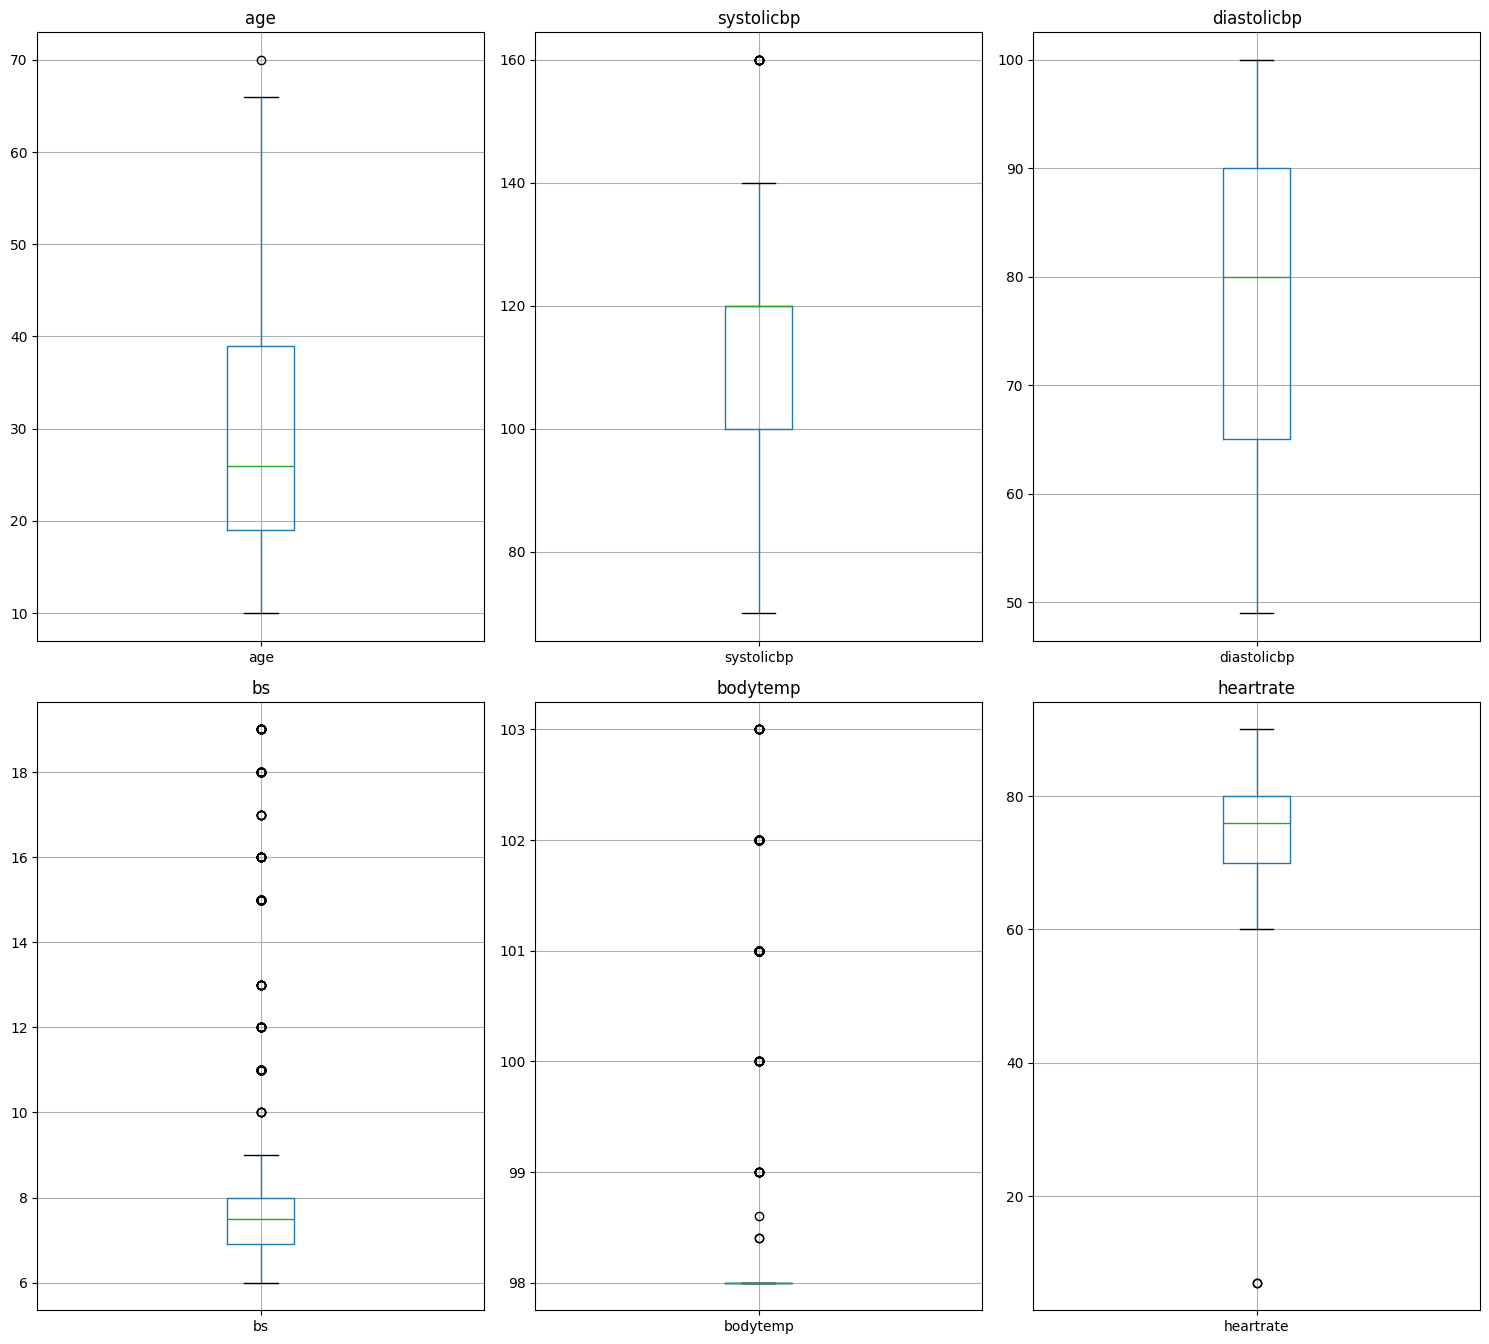

In [ ]:
fig = plt.figure(figsize=(15, 20))
for i, column in enumerate(maternal_health_risk.columns):
    if maternal_health_risk[column].dtype != 'object':
        ax = fig.add_subplot(3, 3, i+1)
        maternal_health_risk.boxplot(column, ax = ax)
        plt.title(column)

plt.tight_layout()
plt.show()

Видим аномальные значения в `heartrate` и `age`

Посмотрим на age

In [ ]:
maternal_health_risk.query('age >= 70')

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
338,70,85,60,6.9,102.0,70,low risk


Мы видим, что все показатели в норме, и беременность в 70 лет вполне возможна. Это не является аномальным значением.

Посмотрим на heartrate

In [ ]:
maternal_health_risk.query('heartrate < 60')

,age,systolicbp,diastolicbp,bs,bodytemp,heartrate,risklevel
499,16,120,75,7.9,98.0,7,low risk
908,16,120,75,7.9,98.0,7,low risk


Видим аномальные значения. Нормальный сердечный ритм для взрослого человека обычно составляет от 60 до 100 ударов в минуту в состоянии покоя. Значение 7 ударов в минуту является значительно ниже нормального диапазона и может быть признаком серьезной проблемы, такой как остановка сердца. Уровень риска должен быть крайне высок, а не низок. Следственно  - эти зачения являются выбросами.

In [ ]:
a = maternal_health_risk['heartrate'].count()
b = maternal_health_risk.query('heartrate < 60')['heartrate'].count()
a,b,f'{b/a*100}% Доля удалённых данных от общего объёма.'

(1014, 2, '0.19723865877712032% Доля удалённых данных от общего объёма.')

In [ ]:
maternal_health_risk = maternal_health_risk.query('heartrate >= 60') # удаляем значения
maternal_health_risk.shape

(1012, 7)

**Вывод:**

Были созданы портреты беременных женщин с различными рисками осложнений.
1. Низкий риск характеризуется чаще всего:
- Возраст: 16;20 лет
- Систолическое давление: 120
- Диастолическое давление: 60,80
- Уровень глюкозы в крови: 7,5
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70
2. Средний риск характеризуется чаще всего:
- Возраст: 20;30 лет
- Систолическое давление: 120
- Диастолическое давление: 80
- Уровень глюкозы в крови: 6-8
- Температура тела в фаренгейтах: 98 (повышается количество людей с 101, относительно высокого риска)
- Частота сердечных сокращений: 70
3. Высокий риск характеризуется чаще всего:
- Возраст: около 40 лет
- Систолическое давление: 120, 140
- Диастолическое давление: 90, 100
- Уровень глюкозы в крови: 11, 15
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70, 80, 90

Так же мы:

- Посмотрели аномальные значения в столбцах `heartrate` и `age`
- Удалили аномальные значения в `heartrate`, так как значение 7 ударов в минуту является аномальным и значительно ниже нормального диапазона и может быть признаком остановки сердца



# Корреляционный анализ


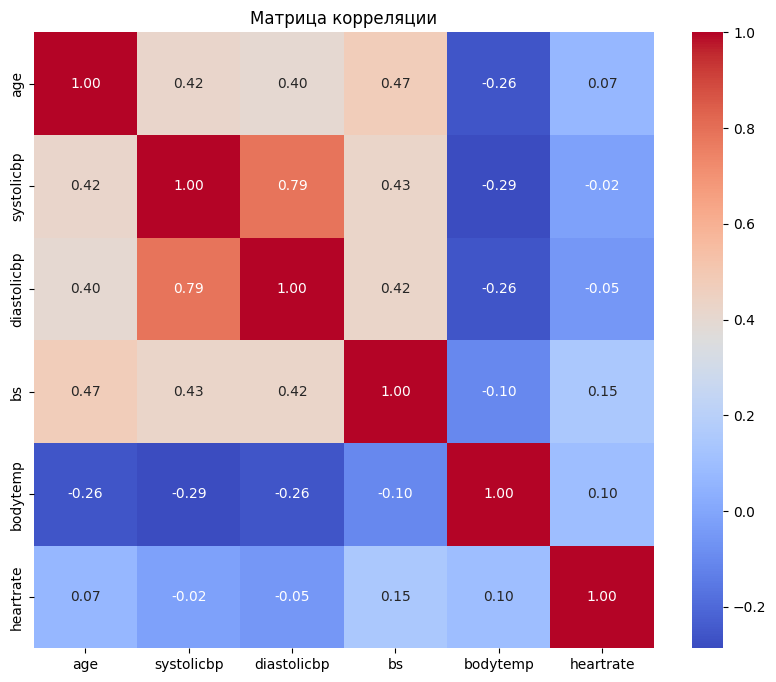

In [ ]:
num = maternal_health_risk.drop(columns = 'risklevel')
plt.figure(figsize=(10, 8))
sns.heatmap(num.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

**Видим высокую корреляцию между систолическим давлением и диастолическим давлением**

# Строим пайплайн

In [ ]:
y = maternal_health_risk['risklevel']
X = maternal_health_risk.drop(columns = 'risklevel')
y.shape,X.shape

((1012,), (1012, 6))

In [ ]:
y.value_counts()

,count
risklevel,
low risk,404
mid risk,336
high risk,272


In [ ]:
enc = LabelEncoder() # кодируем основной признак
y=enc.fit_transform(y)

In [ ]:
pd.Series(y).value_counts()

,count
1,404
2,336
0,272


*   высокий риск - 0
*   маленький риск - 1
*   средний риск - 2



In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,
                                                  test_size = TEST_SIZE, random_state = RANDOM_STATE)
num_columns = [col for col in X]
data_preprocessor = ColumnTransformer([('num', MinMaxScaler(), num_columns)], remainder='passthrough')

pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', KNeighborsClassifier())])
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,10),
        'models__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']
    },
    # словарь для модели XGBClassifier()
    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
]

In [ ]:
grid_search = GridSearchCV(pipe_final,
                           param_grid,
                           cv=10,
                           scoring='accuracy',
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n')
display(grid_search.best_estimator_)
print('Среднее значение метрики accuracy на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'systolicbp',
                                                   'diastolicbp', 'bs',
                                                   'bodytemp',
                                                   'heartrate'])])),
                ('models',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

Среднее значение метрики accuracy на тренировочной выборке: 0.8330401234567901


Матрица ошибок и accuracy на полном наборе на тренировочных данных

In [ ]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
print("Accuracy модели на тренировочном наборе:", train_score)

Accuracy модели на тренировочном наборе: 0.9295426452410384


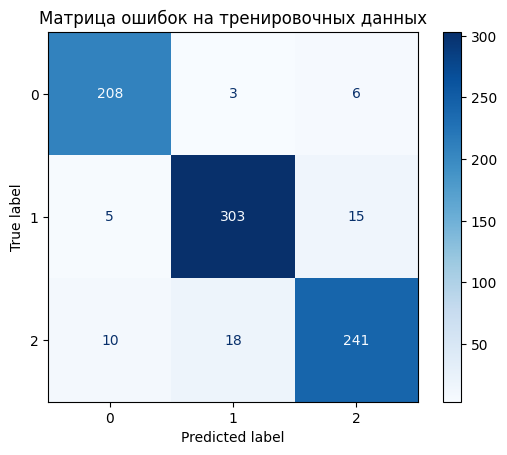

In [ ]:
y_pred_train = grid_search.best_estimator_.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);
plt.title('Матрица ошибок на тренировочных данных');

*   высокий риск - правильных значений (208)
*   маленький риск - правильных значений (303)
*   средний риск - правильных значений (241)

In [ ]:
results = pd.DataFrame(grid_search.cv_results_).set_index('params')
display(results[['rank_test_score','param_models', 'mean_fit_time','mean_score_time',
                 'mean_test_score']].sort_values(by='rank_test_score').head(2))

,rank_test_score,param_models,mean_fit_time,mean_score_time,mean_test_score
params,,,,,
"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'preprocessor__num': 'passthrough'}",1,"XGBClassifier(base_score=None, booster=None, c...",0.267663,0.015575,0.83304
"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, random_state=42, ...), 'preprocessor__num': MinMaxScaler()}",1,"XGBClassifier(base_score=None, booster=None, c...",0.168566,0.010947,0.83304


## Анализ важности признаков

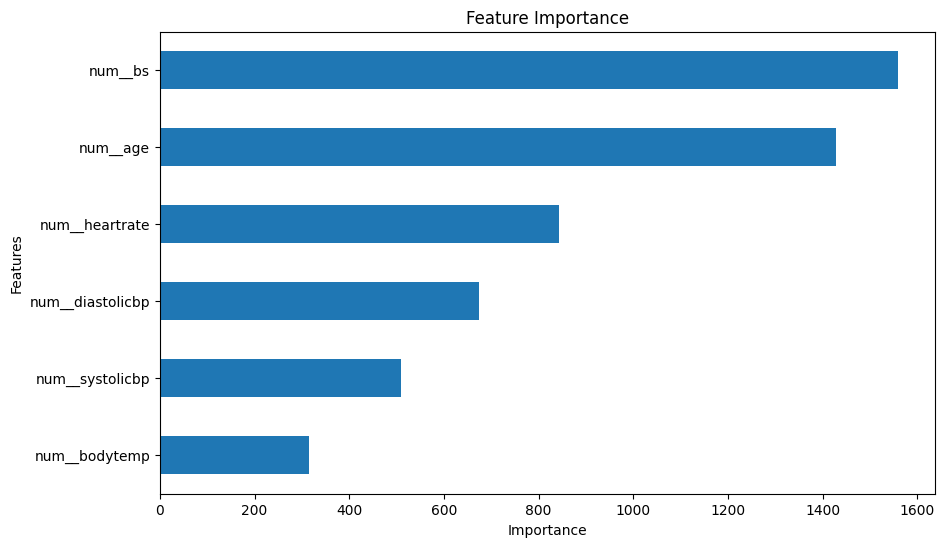

In [ ]:
best_pipeline = grid_search.best_estimator_
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['models']
preprocessor_col = preprocessor.get_feature_names_out()

X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns = preprocessor_col)

model.fit(X_train_preprocessed, y_train)
feature_importance = model.get_booster().get_score(importance_type='weight')# берем вес признаков

data = pd.DataFrame.from_dict(feature_importance,
                              orient='index', columns=['score']).sort_values(by='score', ascending=True)
data.plot(kind='barh', figsize=(10, 6), legend=False)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance');

- Больше всего влияет на модель - уровень клюкозы и  возраст
- Меньше всего влияет - температура тела

## Тестирование

In [ ]:
%%time
model = grid_search.best_estimator_
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f'Значение метрики accuracy:{accuracy_score(y_test,y_pred)}')

Значение метрики accuracy:0.8472906403940886
CPU times: user 218 ms, sys: 7.89 ms, total: 226 ms
Wall time: 124 ms


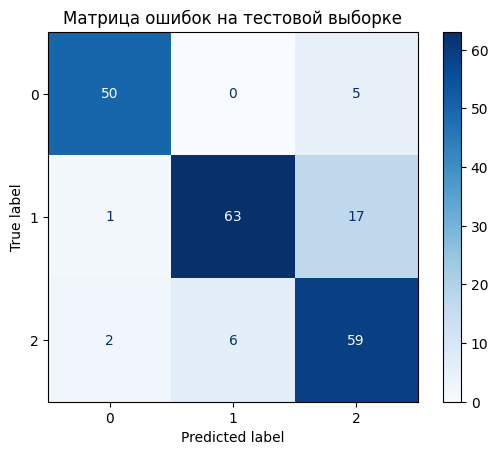

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);
plt.title('Матрица ошибок на тестовой выборке');

*   высокий риск - правильных значений (50)
*   маленький риск - правильных значений (63)
*   средний риск - правильных значений (59)

**Вывод:**

|Лучшая модель|
|---|
|'models': XGBClassifier(random_state=42), 'preprocessor__num': StandardScaler()|

**Метрика accuracy лучшей модели на тренировочной выборке: 0.93**

Матрица ошибок:

*   высокий риск - правильных значений (208)
*   маленький риск - правильных значений (303)
*   средний риск - правильных значений (241)

**Анализ признаков:**

- Больше всего влияет на модель - уровень клюкозы и  возраст
- Меньше всего влияет - температура тела

**На тестовых данных**
**Метрика accuracy лучшей модели на тестовой выборке: 0.85**

Матрица ошибок:

*   высокий риск - правильных значений (50)
*   маленький риск - правильных значений (63)
*   средний риск - правильных значений (59)

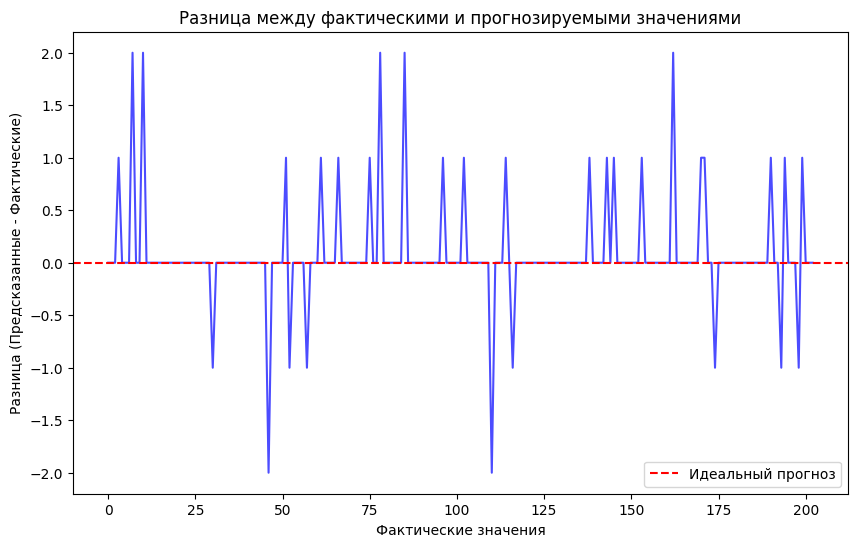

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(y_pred - y_test, alpha=0.7, color="blue")
plt.xlabel("Фактические значения")
plt.ylabel("Разница (Предсказанные - Фактические)")
plt.title("Разница между фактическими и прогнозируемыми значениями")

plt.axhline(y=0, color="red", linestyle="--", label="Идеальный прогноз")  # Линия идеального прогноза

plt.legend()
plt.show()

# Вывод

1) Загрузка данных

- Тип данных во всех столбцах- верный
- Видим аномальные значение в HeartRate

2) Предобработка данных

- привели к змеиному регистру заголовки
- пропусков нет
- неявных дубликатов - нет

3) Исследовательский анализ данных

Были созданы портреты беременных женщин с различными рисками осложнений.

1. Низкий риск характеризуется чаще всего:
- Возраст: 16;20 лет
- Систолическое давление: 120
- Диастолическое давление: 60,80
- Уровень глюкозы в крови: 7,5
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70

2. Средний риск характеризуется чаще всего:
- Возраст: 20;30 лет
- Систолическое давление: 120
- Диастолическое давление: 80
- Уровень глюкозы в крови: 6-8
- Температура тела в фаренгейтах: 98 (повышается количество людей с 101, относительно высокого риска)
- Частота сердечных сокращений: 70

3. Высокий риск характеризуется чаще всего:
- Возраст: около 40 лет
- Систолическое давление: 120, 140
- Диастолическое давление: 90, 100
- Уровень глюкозы в крови: 11, 15
- Температура тела в фаренгейтах: 98
- Частота сердечных сокращений: 70, 80, 90

Так же мы:

- Посмотрели аномальные значения в столбцах `heartrate` и `age`
- Удалили аномальные значения в `heartrate`, так как значение 7 ударов в минуту является аномальным и значительно ниже нормального диапазона и может быть признаком остановки сердца

4) Корреляционный анализ

Видим высокую корреляцию между систолическим давлением и диастолическим давлением

5) Строим модель

|Лучшая модель|
|---|
|'models': XGBClassifier(random_state=42), 'preprocessor__num': StandardScaler()|

**Метрика accuracy лучшей модели на тренировочной выборке: 0.93**
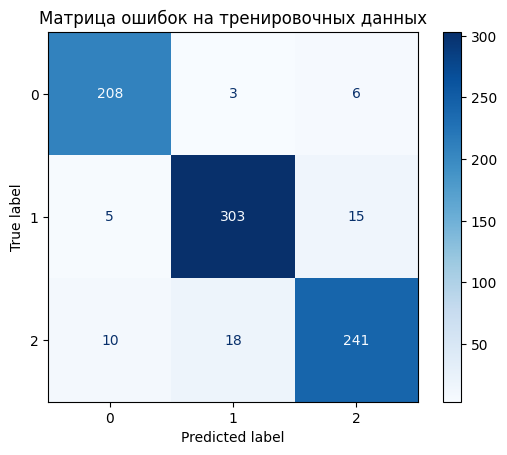
*   высокий риск - правильных значений (208)
*   маленький риск - правильных значений (303)
*   средний риск - правильных значений (241)

**Анализ признаков:**

- Больше всего влияет на модель - уровень клюкозы и  возраст
- Меньше всего влияет - температура тела

**На тестовых данных**
**Метрика accuracy лучшей модели на тестовой выборке: 0.85**
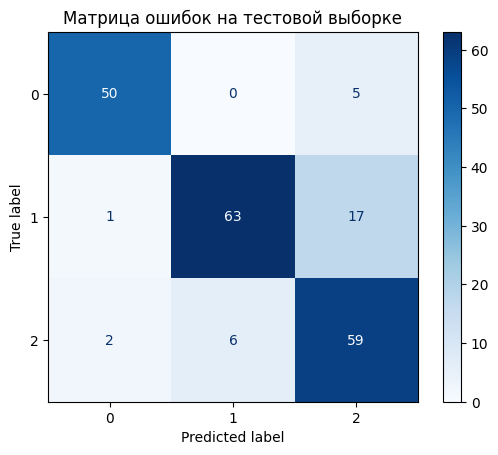

*   высокий риск - правильных значений (50)
*   маленький риск - правильных значений (63)
*   средний риск - правильных значений (59)

Accuracy модели на тренировочном наборе: 0.9295426452410384


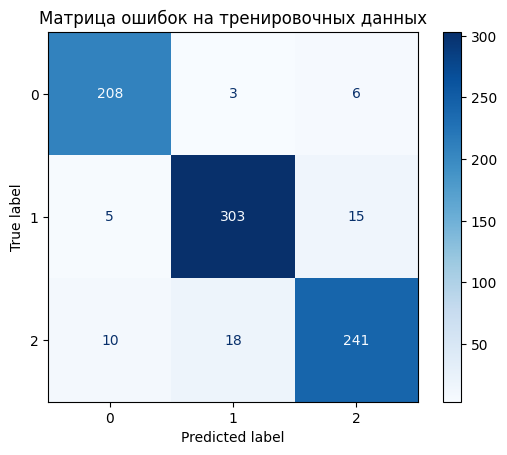

In [ ]:
# на тренировочных
model = grid_search.best_estimator_
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
print("Accuracy модели на тренировочном наборе:", train_score)

y_pred_train = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);
plt.title('Матрица ошибок на тренировочных данных');


Значение метрики accuracy:0.8472906403940886


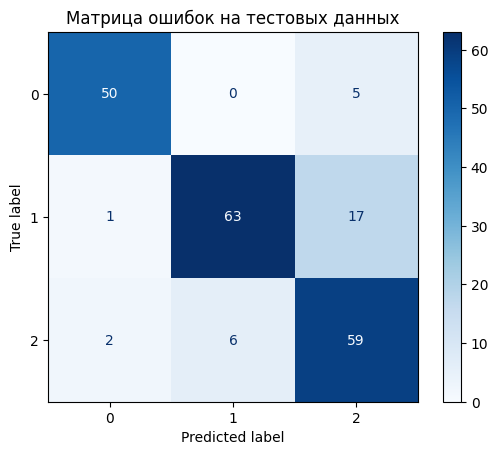

In [ ]:
# на тестовых
y_pred = model.predict(X_test)
print(f'Значение метрики accuracy:{accuracy_score(y_test,y_pred)}')
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues);
plt.title('Матрица ошибок на тестовых данных');